Import modules

In [1]:
# public
import os
import argparse
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image

# custom
from DCL_finegrained import model
from utee import selector
from utee.Normalize import Normalize
from loader_checkpoint import *
from dct import *
from utils import *

ArgumentParser

In [2]:
parser0 = argparse.ArgumentParser(description='Transferable Perturbation via Frequency Manipulation')
parser0.add_argument('--epochs', type=int, default=0, help='Model checkpoint epoch number')
parser0.add_argument('--eps', type=int, default=10, help='Perturbation budget (0~255)')
parser0.add_argument('--model_type', type=str, default='vgg16', help='Victim model: vgg16, vgg19, res152, dense169')
parser0.add_argument('--RN', type=lambda x: (str(x).lower() == 'true'), default=False, help='If true, activating the Random Normalization module in training phase')
parser0.add_argument('--DA', type=lambda x: (str(x).lower() == 'true'), default=False, help='If true, activating the Domain-agnostic Attention module in training phase')
parser0.add_argument('--FA', type=lambda x: (str(x).lower() == 'true'), default=False, help='If true, activating the Frequency Augmentation module in training phase')
parser0.add_argument('--iter_ckpt', type=lambda x: (str(x).lower() == 'true'), default=False, help='If true, Model checkpoint with iteration number')
parser0.add_argument('--iter', type=int, default=0, help='Model checkpoint iteration number')
args0 = parser0.parse_args(args=[])
print(args0)

Namespace(DA=False, FA=False, RN=False, epochs=0, eps=10, model_type='vgg16')


In [15]:
parser = argparse.ArgumentParser(description='Transferable Perturbation via Frequency Manipulation')
parser.add_argument('--epochs', type=int, default=0, help='Model checkpoint epoch number')
parser.add_argument('--eps', type=int, default=10, help='Perturbation budget (0~255)')
parser.add_argument('--model_type', type=str, default='vgg16', help='Victim model: vgg16, vgg19, res152, dense169')
parser.add_argument('--RN', type=lambda x: (str(x).lower() == 'true'), default=False, help='If true, activating the Random Normalization module in training phase')
parser.add_argument('--DA', type=lambda x: (str(x).lower() == 'true'), default=False, help='If true, activating the Domain-agnostic Attention module in training phase')
parser.add_argument('--FA', type=lambda x: (str(x).lower() == 'true'), default=True, help='If true, activating the Frequency Augmentation module in training phase')
parser.add_argument('--iter_ckpt', type=lambda x: (str(x).lower() == 'true'), default=True, help='If true, Model checkpoint with iteration number')
parser.add_argument('--iter', type=int, default=10000, help='Model checkpoint iteration number')
args = parser.parse_args(args=[])
print(args)

Namespace(DA=False, FA=True, RN=False, epochs=0, eps=10, model_type='vgg16')


Eval

In [16]:
# Choose the domain sets for evaluating the cross-domain transferability
domain_list = ['cifar10', 'cifar100', 'stl10', 'svhn', 'dcl_dub', 'dcl_car', 'dcl_air', 'imagenet', 'imagenet_incv3']
domain = 'imagenet'
print('='*30, '{}'.format(domain), "="*30)

# Load the victim model (imagenet)
if domain[:3] == 'dcl': # CUB-200-2011, Stanford Cars, FGVC Aircraft
    batch_size = 6
    if domain == 'dcl_cub':
        numcls = 200
    elif domain == 'dcl_car':
        numcls = 196
    elif domain == 'dlc_air':
        numcls = 100
elif domain == 'imagenet_incv3':
    batch_size = 16
elif domain == 'imagenet':
    batch_size = 32
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    model_vgg16 = nn.Sequential(Normalize(mean,std), torchvision.models.vgg16(pretrained=True)).cuda().eval()
    model_vgg19 = nn.Sequential(Normalize(mean,std), torchvision.models.vgg19(pretrained=True)).cuda().eval()
    model_res50 = nn.Sequential(Normalize(mean,std), torchvision.models.resnet50(pretrained=True)).cuda().eval()
    model_res152 = nn.Sequential(Normalize(mean,std), torchvision.models.resnet152(pretrained=True)).cuda().eval()
    model_dense121 = nn.Sequential(Normalize(mean,std), torchvision.models.densenet121(pretrained=True)).cuda().eval()
    model_dense169 = nn.Sequential(Normalize(mean,std), torchvision.models.densenet169(pretrained=True)).cuda().eval()
else: # CIFAR-10, CIFAR-100, STL-10, SVHN
    batch_size = 128

# Load the validation dataset & victim model (others)
if domain == 'imagenet':
    ds_fetcher, is_imagenet = selector.select(domain)
elif domain[:3] == 'dcl': # CUB-200-2011, Stanford Cars, FGVC Aircraft
    model_res50, model_senet, model_seres101, ds_fetcher, is_imagenet = selector.select(domain)
    acc_res50, clean_res50, acc_senet, clean_senet, acc_seres101, clean_seres101 = 0,0,0,0,0,0
else:  # CIFAR-10, CIFAR-100, STL-10, SVHN
    model_raw, ds_fetcher, is_imagenet = selector.select(domain)
    
if domain[-5:] == 'incv3':
    ds_val = ds_fetcher(batch_size=batch_size, input_size=299, train=False, val=True)
    data_length = len(ds_fetcher(batch_size=1, train=False, val=True))
else:
    ds_val = ds_fetcher(batch_size=batch_size, train=False, val=True)
    data_length = len(ds_fetcher(batch_size=1, train=False, val=True))
print('Validation data length:', data_length)

# Load the generative model (attacker)
netG = load_gan(args, domain).cuda().eval()
netG_BIA = load_gan(args0, domain).cuda().eval()

============================== imagenet ==============================
Building and initializing imagenet parameters
Building IMAGENET data loader, 50000 for train, 50000 for test
Building IMAGENET data loader, 50000 for train, 50000 for test
Validation data length: 50000
Substitute Model: vgg16 	 RN: False 	 DA: False 	 FA: True 	 Saving instance: 0
Substitute Model: vgg16 	 RN: False 	 DA: False 	 FA: False 	 Saving instance: 0


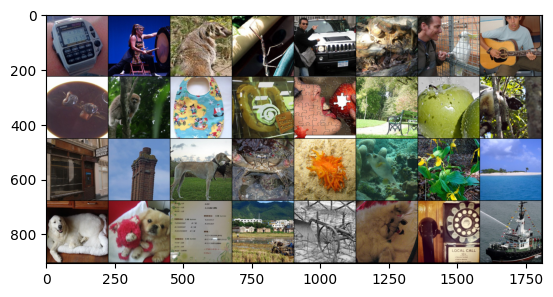

In [17]:
img, label = next(iter(ds_val))
img = Variable(torch.FloatTensor(img)).cuda()
label = Variable(torch.from_numpy(np.array(label)).long().cuda())

img_grid = make_grid(img.cpu())
plt.imshow(img_grid.permute(1,2,0))

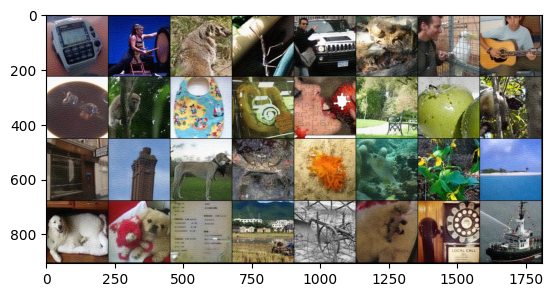

In [18]:
adv = netG(img)
adv = torch.min(torch.max(adv, img - args.eps/255.0), img + args.eps/255.0)
adv = torch.clamp(adv, 0.0, 1.0)

adv0 = netG_BIA(img)
adv0 = torch.min(torch.max(adv0, img - args.eps/255.0), img + args.eps/255.0)
adv0 = torch.clamp(adv0, 0.0, 1.0)

adv_grid = make_grid(adv.cpu())
plt.imshow(adv_grid.permute(1,2,0))

(-0.5, 223.5, 223.5, -0.5)

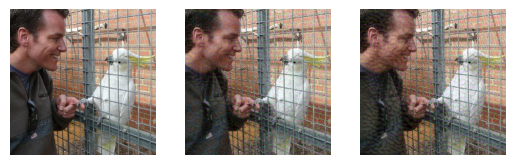

In [26]:
# Save the images
i = 6
plt.subplot(131)
plt.imshow(img[i,...].permute(1,2,0).detach().cpu())
plt.axis('off')
plt.subplot(132)
plt.imshow(adv0[i,...].permute(1,2,0).detach().cpu())
plt.axis('off')
plt.subplot(133)
plt.imshow(adv[i,...].permute(1,2,0).detach().cpu())
plt.axis('off')
# save_path = 'eval_batch/{}'.format(args.model_type)
# if not os.path.exists(save_path):
#     os.makedirs(save_path)
# plt.savefig(os.path.join(save_path, '{}.png'.format(i)), bbox_inches='tight')

In [20]:
# Initialize the classification accuracy (clean & attack)
clean_vgg16, clean_vgg19, clean_res50, clean_res152, clean_dense121, clean_dense169 = 0,0,0,0,0,0
acc_vgg16, acc_vgg19, acc_res50, acc_res152, acc_dense121, acc_dense169 = 0,0,0,0,0,0
clean, accuracy = 0, 0
data_length = batch_size

with torch.no_grad():
    if domain == 'imagenet':
        clean_vgg16 += torch.sum(torch.argmax(model_vgg16(img), dim=1) == label.cuda())
        acc_vgg16 += torch.sum(torch.argmax(model_vgg16(adv), dim=1) == label.cuda())
        
        clean_vgg19 += torch.sum(torch.argmax(model_vgg19(img), dim=1) == label.cuda())
        acc_vgg19 += torch.sum(torch.argmax(model_vgg19(adv), dim=1) == label.cuda())
        
        clean_res50 += torch.sum(torch.argmax(model_res50(img), dim=1) == label.cuda())
        acc_res50 += torch.sum(torch.argmax(model_res50(adv), dim=1) == label.cuda())
        
        clean_res152 += torch.sum(torch.argmax(model_res152(img), dim=1) == label.cuda())
        acc_res152 += torch.sum(torch.argmax(model_res152(adv), dim=1) == label.cuda())
        
        clean_dense121 += torch.sum(torch.argmax(model_dense121(img), dim=1) == label.cuda())
        acc_dense121 += torch.sum(torch.argmax(model_dense121(adv), dim=1) == label.cuda())
        
        clean_dense169 += torch.sum(torch.argmax(model_dense169(img), dim=1) == label.cuda())
        acc_dense169 += torch.sum(torch.argmax(model_dense169(adv), dim=1) == label.cuda())
    
    elif domain[:3] != 'dcl': # CIFAR-10, CIFAR-100, STL-10, SVHN
        clean += torch.sum(torch.argmax(model_raw(img), dim=1) == label.cuda())
        accuracy += torch.sum(torch.argmax(model_raw(adv), dim=1) == label.cuda())
        
    else: # CUB-200-2011, Stanford Cars, FGVC Aircraft
        outputs = model_res50(adv)
        outputs_clean = model_res50(img)
        outputs_pred = outputs[0] + outputs[1][:,0:numcls] + outputs[1][:,numcls:2*numcls]
        outputs_pred_clean = outputs_clean[0] + outputs_clean[1][:,0:numcls] + outputs_clean[1][:,numcls:2*numcls]
        acc_res50 += torch.sum(torch.argmax(outputs_pred, dim=1) == label.cuda())
        clean_res50 += torch.sum(torch.argmax(outputs_pred_clean, dim=1) == label.cuda())
        
        outputs2 = model_senet(adv)
        outputs_clean2 = model_senet(img)
        outputs_pred2 = outputs2[0] + outputs2[1][:,0:numcls] + outputs2[1][:,numcls:2*numcls]
        outputs_pred_clean2 = outputs_clean2[0] + outputs_clean2[1][:,0:numcls] + outputs_clean2[1][:,numcls:2*numcls]
        acc_senet += torch.sum(torch.argmax(outputs_pred2, dim=1) == label.cuda())
        clean_senet += torch.sum(torch.argmax(outputs_pred_clean2, dim=1) == label.cuda())
        
        outputs3 = model_seres101(adv)
        outputs_clean3 = model_seres101(img)
        outputs_pred3 = outputs3[0] + outputs3[1][:,0:numcls] + outputs3[1][:,numcls:2*numcls]
        outputs_pred_clean3 = outputs_clean3[0] + outputs_clean3[1][:,0:numcls] + outputs_clean3[1][:,numcls:2*numcls]
        acc_seres101 += torch.sum(torch.argmax(outputs_pred3, dim=1) == label.cuda())
        clean_seres101 += torch.sum(torch.argmax(outputs_pred_clean3, dim=1) == label.cuda())
    
if domain == 'imagenet':
    print('----------------vgg16----------------')
    print(clean_vgg16 / data_length)
    print(acc_vgg16 / data_length)
    print('----------------vgg19----------------')
    print(clean_vgg19 / data_length)
    print(acc_vgg19 / data_length)
    print('----------------res50----------------')
    print(clean_res50 / data_length)
    print(acc_res50 / data_length)      
    print('----------------res152----------------')
    print(clean_res152 / data_length)
    print(acc_res152 / data_length)
    print('----------------dense121----------------')
    print(clean_dense121 / data_length)
    print(acc_dense121 / data_length)
    print('----------------dense169----------------')
    print(clean_dense169 / data_length)
    print(acc_dense169 / data_length)
    
elif domain[:3] == 'dcl': # CUB-200-2011, Stanford Cars, FGVC Aircraft
    print('----------------backbone:res50----------------')
    print(clean_res50 / data_length)
    print(acc_res50 / data_length)
    print('----------------backbone:se-net----------------')
    print(clean_senet / data_length)
    print(acc_senet / data_length)
    print('----------------backbone:se-res101----------------')
    print(clean_seres101 / data_length)
    print(acc_seres101 / data_length)

else: # CIFAR-10, CIFAR-100, STL-10, SVHN
    print(clean / data_length)
    print(accuracy / data_length)


----------------vgg16----------------
tensor(0.7188, device='cuda:0')
tensor(0.1875, device='cuda:0')
----------------vgg19----------------
tensor(0.6562, device='cuda:0')
tensor(0.1875, device='cuda:0')
----------------res50----------------
tensor(0.7188, device='cuda:0')
tensor(0.3438, device='cuda:0')
----------------res152----------------
tensor(0.6250, device='cuda:0')
tensor(0.4688, device='cuda:0')
----------------dense121----------------
tensor(0.7188, device='cuda:0')
tensor(0.3438, device='cuda:0')
----------------dense169----------------
tensor(0.6875, device='cuda:0')
tensor(0.3438, device='cuda:0')


In [2]:
i = [0,1,2,3,4]

for i in [0,1,2,3,4]:
    if i%2==0 and i>0:
        print(i)
    

2
4
